In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion

import emcee

%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [2]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_10/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_10/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

     CV_ventricles  CV_atria  a_atria   EDP_lv   EDP_rv     Rsys    Rpulm
0         0.583426  0.559737  2.63999  3.00130  4.86389  2.62436  1.74940
1         0.513584  0.679305  3.15695  5.65473  6.89338  2.07232  3.77998
2         0.528843  0.596498  4.85812  5.02497  2.16558  1.34170  2.09279
3         0.576382  0.320044  2.30249  3.45923  3.79267  1.44626  3.62270
4         0.706760  0.986539  1.47919  2.71888  3.53382  3.55907  3.37904
..             ...       ...      ...      ...      ...      ...      ...
995       0.492465  0.433849  3.11757  1.13969  5.68550  2.69079  1.14159
996       0.693082  0.775705  3.06761  3.16270  5.87700  2.03175  3.11116
997       0.383862  0.422026  3.75881  2.76191  7.32266  2.90629  2.73541
998       0.391658  0.580093  3.14632  7.38027  6.52224  3.83890  1.65956
999       0.488805  0.328415  4.39081  5.60215  1.67397  1.75135  3.87967

[1000 rows x 7 columns]


In [3]:
mask = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_10/output_mask_beat_5.txt',index_col=None,delim_whitespace=True,header=None)

In [4]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_10/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_10/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)

     LVedv  LVedp   LVesv  LVpMax  LVdpdtMax  LVdpdtMin   RVedv  RVedp  \
0   167.78   5.84  118.11   93.76       1726       -709  133.88   2.44   
1   141.10   4.37   96.59   75.32       1473       -564  131.79   3.18   
2   142.30   4.95   79.35   76.89       1591       -626  179.98   2.76   
3   143.07   3.12   89.46   71.14       1470       -560  160.68   2.88   
4   163.04   4.87  118.61  104.88       1851       -801  150.54   2.19   
..     ...    ...     ...     ...        ...        ...     ...    ...   
71  131.58   4.84   76.58   81.69       1847       -666  165.19   3.00   
72  157.00   5.91  107.64  107.75       1975       -844  153.31   1.93   
73  139.09   4.27   97.86   88.56       1625       -686  138.71   2.24   
74  157.62   7.52  108.61   98.41       1858       -738  122.12   2.90   
75  156.26   4.12  108.01   87.15       1698       -682  150.00   2.69   

     RVesv  RVpMax  ...  RAvMax  RApMax  LAsvA  LAinflV  LAsvV  RAsvA  \
0    87.71   23.96  ...   91.58    2.6

In [5]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]

In [6]:
input_masked=input_masked.iloc[np.array(mask==1),]
input_masked.index = y_all.index

In [7]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[0.386498, 0.799253]
[0.305504, 1.02567]
[1.47919, 4.96054]
[1.05607, 7.27469]
[1.06364, 7.4999]
[1.02992, 3.98405]
[1.03672, 3.85692]


In [8]:
y_calibration = y_all.loc[:,['A_TAT','V_TAT','LVpMax']]

y_calibration2 = pd.DataFrame({'LV_EF':(y_all.loc[:,'LVedv']-y_all.loc[:,'LVesv'])/y_all.loc[:,'LVedv']})

y_calibration=y_calibration.join(y_calibration2)

In [9]:
y_train = torch.tensor(y_calibration.values)
x_train = torch.tensor(input_masked.values)

In [10]:
new_labels = x_labels.values.copy()
for i,l in enumerate(new_labels):
    new_labels[i] = str(l)+"_one_over"

In [11]:
new_X_one_over = 1/input_masked
new_X_one_over.columns = new_labels[0:15]
new_X_one_over

,"(['CV_ventricles']_one_over,)","(['CV_atria']_one_over,)","(['a_atria']_one_over,)","(['EDP_lv']_one_over,)","(['EDP_rv']_one_over,)","(['Rsys']_one_over,)","(['Rpulm']_one_over,)"
0,1.714013,1.786553,0.378789,0.333189,0.205597,0.381045,0.571625
1,1.947101,1.472093,0.316761,0.176843,0.145067,0.482551,0.264552
2,1.890920,1.676452,0.205841,0.199006,0.461770,0.745323,0.477831
3,1.734960,3.124570,0.434312,0.289082,0.263666,0.691439,0.276037
4,1.414907,1.013645,0.676046,0.367799,0.282980,0.280972,0.295942
...,...,...,...,...,...,...,...
71,1.285294,1.540092,0.389196,0.139433,0.247329,0.564509,0.346221
72,2.176568,1.918988,0.293681,0.236850,0.314964,0.308773,0.532059
73,2.564622,2.897938,0.273640,0.170526,0.182531,0.340158,0.276544
74,1.335094,1.078386,0.404071,0.162916,0.138912,0.361210,0.789353


In [12]:
new_X_adjust=pd.concat([input_masked,new_X_one_over],axis=1)

In [13]:
# split original dataset in training, validation and testing sets
X=input_masked
y=y_calibration 
X.columns = X.columns.astype(str)
y.columns = y.columns.astype(str)
X_n_train, X_n_test, y_n_train, y_n_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=seed
)

In [14]:
new_X_one_over = 1/X_n_train
new_X_one_over.columns = new_labels[0:15]
new_X_one_over

new_X_one_over_test = 1/X_n_test
new_X_one_over_test.columns = new_labels[0:15]
new_X_one_over_test

,"(['CV_ventricles']_one_over,)","(['CV_atria']_one_over,)","(['a_atria']_one_over,)","(['EDP_lv']_one_over,)","(['EDP_rv']_one_over,)","(['Rsys']_one_over,)","(['Rpulm']_one_over,)"
53,1.295305,2.345370,0.305698,0.524439,0.330016,0.253564,0.507197
36,1.770523,1.194202,0.538077,0.165100,0.414147,0.598018,0.692631
70,1.259392,1.679995,0.392770,0.139621,0.251387,0.301289,0.291660
17,1.698750,2.299495,0.248946,0.760751,0.277429,0.257476,0.287176
41,2.574877,1.157006,0.358396,0.308417,0.146104,0.319132,0.259626
12,1.266559,1.508673,0.446554,0.207077,0.377856,0.491304,0.465515
27,1.618071,1.782061,0.568573,0.171163,0.183138,0.330927,0.286574
15,2.047112,1.630579,0.275823,0.216096,0.393955,0.834425,0.349488


In [15]:
X_over_train=pd.concat([X_n_train,new_X_one_over],axis=1)
X_over_test =pd.concat([X_n_test,new_X_one_over_test],axis=1)
X_over_train.columns = X_over_train.columns.astype(str)
X_over_test.columns = X_over_test.columns.astype(str)

In [1]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score


model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(degree=1, include_bias=False,interaction_only=True)),
    ('lasso', MultiTaskLassoCV(n_alphas=100,max_iter=1000))
])

# fit to an order-3 polynomial data
model = model.fit(X_over_train, y_n_train)
lasso_coef=model.named_steps['lasso'].coef_

NameError: name 'X_over_train' is not defined

In [ ]:
r2_score(y_n_test,model.predict(X_over_test))

In [18]:
y_n_test

,A_TAT,V_TAT,LVpMax,LV_EF
53,205.630,78.6433,111.49,0.258237
36,102.239,107.6100,88.75,0.445018
70,143.179,77.2952,102.51,0.334111
17,202.760,103.6430,96.30,0.225699
41,100.949,161.4530,81.94,0.224884
12,129.360,76.5869,92.34,0.399421
27,153.320,100.3050,93.94,0.304857
15,140.711,123.9860,71.70,0.435395


In [19]:
np.max(lasso_coef,axis=0)

array([ 5.91750353e-04,  2.78582306e-02,  8.57632340e-02,  1.77987012e+00,
        1.54678276e+00,  9.04143261e+00, -7.10367092e-03,  2.40622948e+01,
        4.97364132e+01,  0.00000000e+00,  0.00000000e+00,  2.26980051e-01,
        2.13303473e-01,  1.96937743e+00])

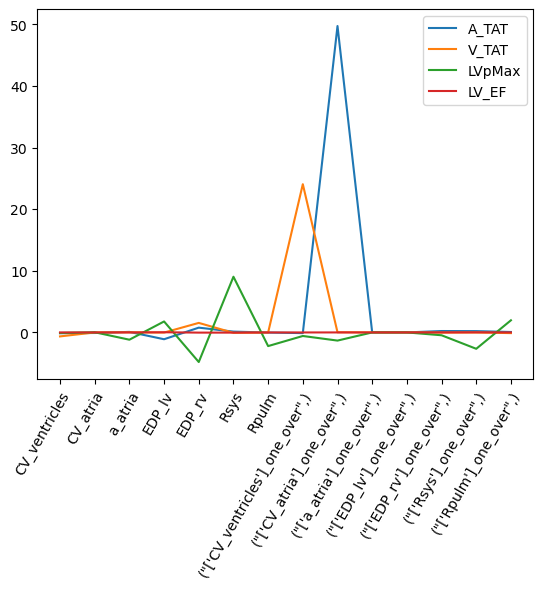

In [20]:
fig, ax = plt.subplots()
plt.plot(X_over_test.columns,(lasso_coef).T)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");
plt.legend(y.columns)

In [21]:
1-((y_n_test-model.predict(X_over_test))**2).mean()/np.var(y_n_test)

A_TAT     0.999399
V_TAT     0.999481
LVpMax    0.926410
LV_EF     0.998051
dtype: float64

In [22]:


model = Pipeline(steps=[
    ('preprocessor', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lasso', MultiTaskLassoCV(n_alphas=100,max_iter=10000))
])
# fit to an order-3 polynomial data
model = model.fit(X_over_train, y_n_train)
lasso_coef=model.named_steps['lasso'].coef_

In [23]:
np.max(lasso_coef,axis=0)

array([ 3.07782373e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.99960470e+00,  1.76045750e-01,  1.64649469e+01,
        4.33561885e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.16388190e-02,
       -4.93626149e-04,  0.00000000e+00, -3.16291596e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.17576252e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.12689833e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.69479757e+00, -1.37704484e-03,  5.49493303e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.30014869e-03,
        0.00000000e+00,  7.10571556e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

Text(0.5, 0, 'Polynomial inputs')

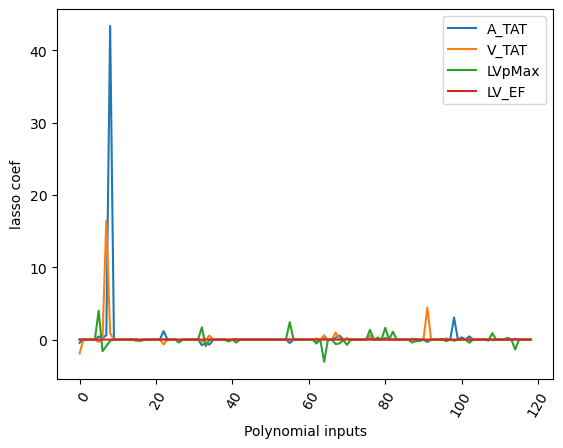

In [24]:
fig, ax = plt.subplots()
plt.plot((lasso_coef).T)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");
plt.legend(y.columns)
plt.ylabel('lasso coef')
plt.xlabel('Polynomial inputs')

In [25]:
r2_score(y_n_test,model.predict(X_over_test))

0.9907700769452521

In [26]:
1-((y_n_test-model.predict(X_over_test))**2).mean()/np.var(y_n_test)

A_TAT     0.999559
V_TAT     0.999853
LVpMax    0.967872
LV_EF     0.995796
dtype: float64

In [27]:
y_shift_train = torch.tensor((y_n_train-model.predict(X_over_train)).values)
x_shift_train = torch.tensor(X_n_train.values)

y_shift_test=torch.tensor((y_n_test-model.predict(X_over_test)).values)
x_shift_test =torch.tensor(X_n_test.values)

In [28]:
emulator = GPE.ensemble(x_shift_train,y_shift_train,training_iter=1000,mean_func='zero')

0
1
2
3


In [29]:
y_shift_test.var(axis=0)

tensor([6.7909e-01, 1.1601e-01, 3.8453e+00, 3.2313e-05], dtype=torch.float64)

In [30]:
emulator.R2(x_shift_test,y_shift_test)

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_score=1-self.MSE(inputVals,outputVals)/torch.tensor(torch.var(outputVals,axis=0))


tensor([0.7490, 0.4722, 0.2829, 0.6182], dtype=torch.float64,
       grad_fn=<RsubBackward1>)

In [31]:
emulator.MSE(x_shift_test,y_shift_test)

tensor([1.7046e-01, 6.1226e-02, 2.7575e+00, 1.2338e-05], dtype=torch.float64,
       grad_fn=<MeanBackward1>)

In [32]:
y_shift_test.var(axis=0)

tensor([6.7909e-01, 1.1601e-01, 3.8453e+00, 3.2313e-05], dtype=torch.float64)

In [33]:
emulator.MSE(x_shift_test,y_shift_test)/y_shift_test.var(axis=0)

tensor([0.2510, 0.5278, 0.7171, 0.3818], dtype=torch.float64,
       grad_fn=<DivBackward0>)

In [34]:
1-(y_n_test-(emulator.predict(x_shift_test).detach().numpy()+model.predict(X_over_test))).mean()**2/np.var(y_n_test)

A_TAT     0.999999
V_TAT     1.000000
LVpMax    0.997212
LV_EF     0.999902
dtype: float64

In [35]:
X_n_train

,CV_ventricles,CV_atria,a_atria,EDP_lv,EDP_rv,Rsys,Rpulm
40,0.739467,0.799121,3.62062,1.89454,5.88510,3.98405,2.48058
2,0.528843,0.596498,4.85812,5.02497,2.16558,1.34170,2.09279
37,0.651165,0.838617,3.17982,3.10041,7.41409,1.38440,3.85692
13,0.692002,0.830007,2.76309,6.82303,7.49990,3.20808,1.54729
54,0.675110,0.599508,3.39513,4.28696,2.18793,1.14643,2.53360
...,...,...,...,...,...,...,...
23,0.423478,0.701941,2.45343,4.50866,2.96756,2.24314,2.67757
67,0.663447,0.821794,4.75323,6.76832,6.68985,3.63406,2.57077
25,0.666809,0.452735,3.79364,2.77021,4.20895,2.20631,1.27496
68,0.474027,0.344367,3.98449,6.74436,4.34718,1.46551,1.50371


In [36]:
x_e_train=torch.tensor(X_n_train.values)
x_e_test=torch.tensor(X_n_test.values)
y_e_train=torch.tensor(y_n_train.values)
y_e_test=torch.tensor(y_n_test.values)

In [37]:
emulator_comp = GPE.ensemble(x_e_train,y_e_train,training_iter=1000,mean_func='linear')

0
1
2
3


In [38]:
emulator_comp.R2(x_e_test,y_e_test)

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_score=1-self.MSE(inputVals,outputVals)/torch.tensor(torch.var(outputVals,axis=0))


tensor([0.9999, 0.9999, 0.9973, 0.9996], dtype=torch.float64,
       grad_fn=<RsubBackward1>)

In [40]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (0.5*np.array(boundsMaxMin)[:,0]<theta).all() and (theta<2*np.array(boundsMaxMin)[:,1]).all():
        return 0.0
    return -np.inf

In [41]:
y_calibration.shape

(76, 4)

In [42]:
def log_likelihood(x,emulator,lasso,y_val,sigma2):
    nMod=y_val.shape[1]
    x=torch.tensor(x)[None]
    x2=torch.cat([x,1/x],axis=1)
    l_mean = torch.tensor(lasso.predict(x2))
    ll =0
    models=emulator.models
    likelihoods=emulator.likelihoods
    inputNorm,outputNorm = emulator.normalise_test_data(x,y_val)
    inputNorm=inputNorm.float()
    outputNorm=outputNorm.float()
    for i in range(nMod):
            models[i].eval()
            likelihoods[i].eval()
            sigma = sigma2[i]
            k = likelihoods[i](models[i](inputNorm)).covariance_matrix.diag()
            mean=l_mean[:,i]
            variance = (emulator.training_output_STD[i]**2)*k+sigma
            
            likelihood_manual=emulator.gaussian_ll(y_val[:,i],mean,variance)
            
            #likelihood_manual=-0.5*((outputVal[:,i]-(self.training_output_STD[i]*m+self.training_output_mean[i]))**2)/((self.training_output_STD[i]**2)*k+sigma) -0.5*torch.log((self.training_output_STD[i]**2)*k+sigma) - 0.5*torch.log(torch.tensor(2*torch.pi))
            ll+= likelihood_manual
    
    
    return ll

In [43]:
def log_prob(theta, emulator,lasso,y_val,sigma2):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return (lp + log_likelihood(theta,emulator,lasso,y_val,sigma2)).detach().numpy()

In [44]:
y_train = torch.tensor(y_calibration.values)
x_train = torch.tensor(input_masked.values)

In [45]:
y_max=y_train.max(axis=0)

In [46]:
y_max

torch.return_types.max(
values=tensor([286.0400, 161.4530, 117.5800,   0.4480], dtype=torch.float64),
indices=tensor([20, 41, 58, 54]))

In [47]:
y_test = y_train[y_max[1][2],:]
x_test = x_train[y_max[1][2],:]

y_train = y_train[~torch.all(y_train == y_test, dim=1)]
x_train = x_train[~torch.all(x_train == x_test, dim=1)]
x_lasso_train=torch.cat([x_train,1/x_train],axis=1)

In [48]:
lasso_model = model.fit(x_lasso_train, y_train)

In [49]:
y_shift_train=y_train-torch.tensor(lasso_model.predict(x_lasso_train))

In [50]:
emulator=GPE.ensemble(x_train,y_shift_train,training_iter=1000,mean_func='zero')

0
1
2
3


In [51]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2
ndim = input_masked.shape[1]
nwalkers = 18
p0 = np.random.uniform(0,1,(nwalkers,ndim))*(np.array(boundsMaxMin)[:,1]-np.array(boundsMaxMin)[:,0])+np.array(boundsMaxMin)[:,0]
y_val = y_test[None]
obs_error=torch.tensor([0.1,0.1,0.1,0.1])

In [52]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,lasso_model,y_val,obs_error])

In [53]:
for i in range(nwalkers):
    print(log_prob(p0[i],emulator,lasso_model,y_val,obs_error))

[-1452.85469953]
[-23078.12798755]
[-5280.64613454]
[-12233.3659706]
[-5327.11326879]
[-13035.71085037]
[-26969.4095576]
[-8555.01202657]
[-1166.76232557]
[-45796.77356815]
[-56332.70813081]
[-9874.39295619]
[-17157.48103131]
[-11755.68818355]
[-38670.23191496]
[-4014.91063889]
[-24203.76630409]
[-3795.20773683]


In [54]:
sampler.run_mcmc(p0, 40000)

State([[ 0.71323906  0.79393151  5.48892606  1.72968225  1.81569199  5.00319394
   3.73136564]
 [ 0.78664903  0.79394643  1.47827869  4.3655995  11.0070607   5.55573747
   0.87289717]
 [ 0.75882152  0.77325054  5.98019598  4.72729217  8.97784054  7.35197518
   3.39307274]
 [ 0.71577512  0.75433732  7.73525525 10.87969971  2.71538417  5.63838317
   7.38568013]
 [ 0.72098538  0.76050441  6.59182452  9.39242367  1.83784359  3.85248605
   2.67173996]
 [ 0.7275072   0.77490695  9.41942059  4.47554072  3.6880704   5.77931445
   4.31515089]
 [ 0.72525594  0.74819137  8.89729421 11.34185777  3.85186818  5.28554036
   5.82300509]
 [ 0.74430936  0.77486395  9.25528138  5.87316787  7.13478554  6.83445457
   4.18528831]
 [ 0.74312251  0.76132054  4.9681276   8.32807735  6.33751814  5.04100443
   3.62983519]
 [ 0.74594095  0.73292007  3.93291454 13.88393818  7.03967161  5.51063567
   6.89355323]
 [ 0.76527906  0.75424719  1.4702452  10.76764032  8.7911479   5.83069524
   5.3825363 ]
 [ 0.73446754  

(54000, 7)


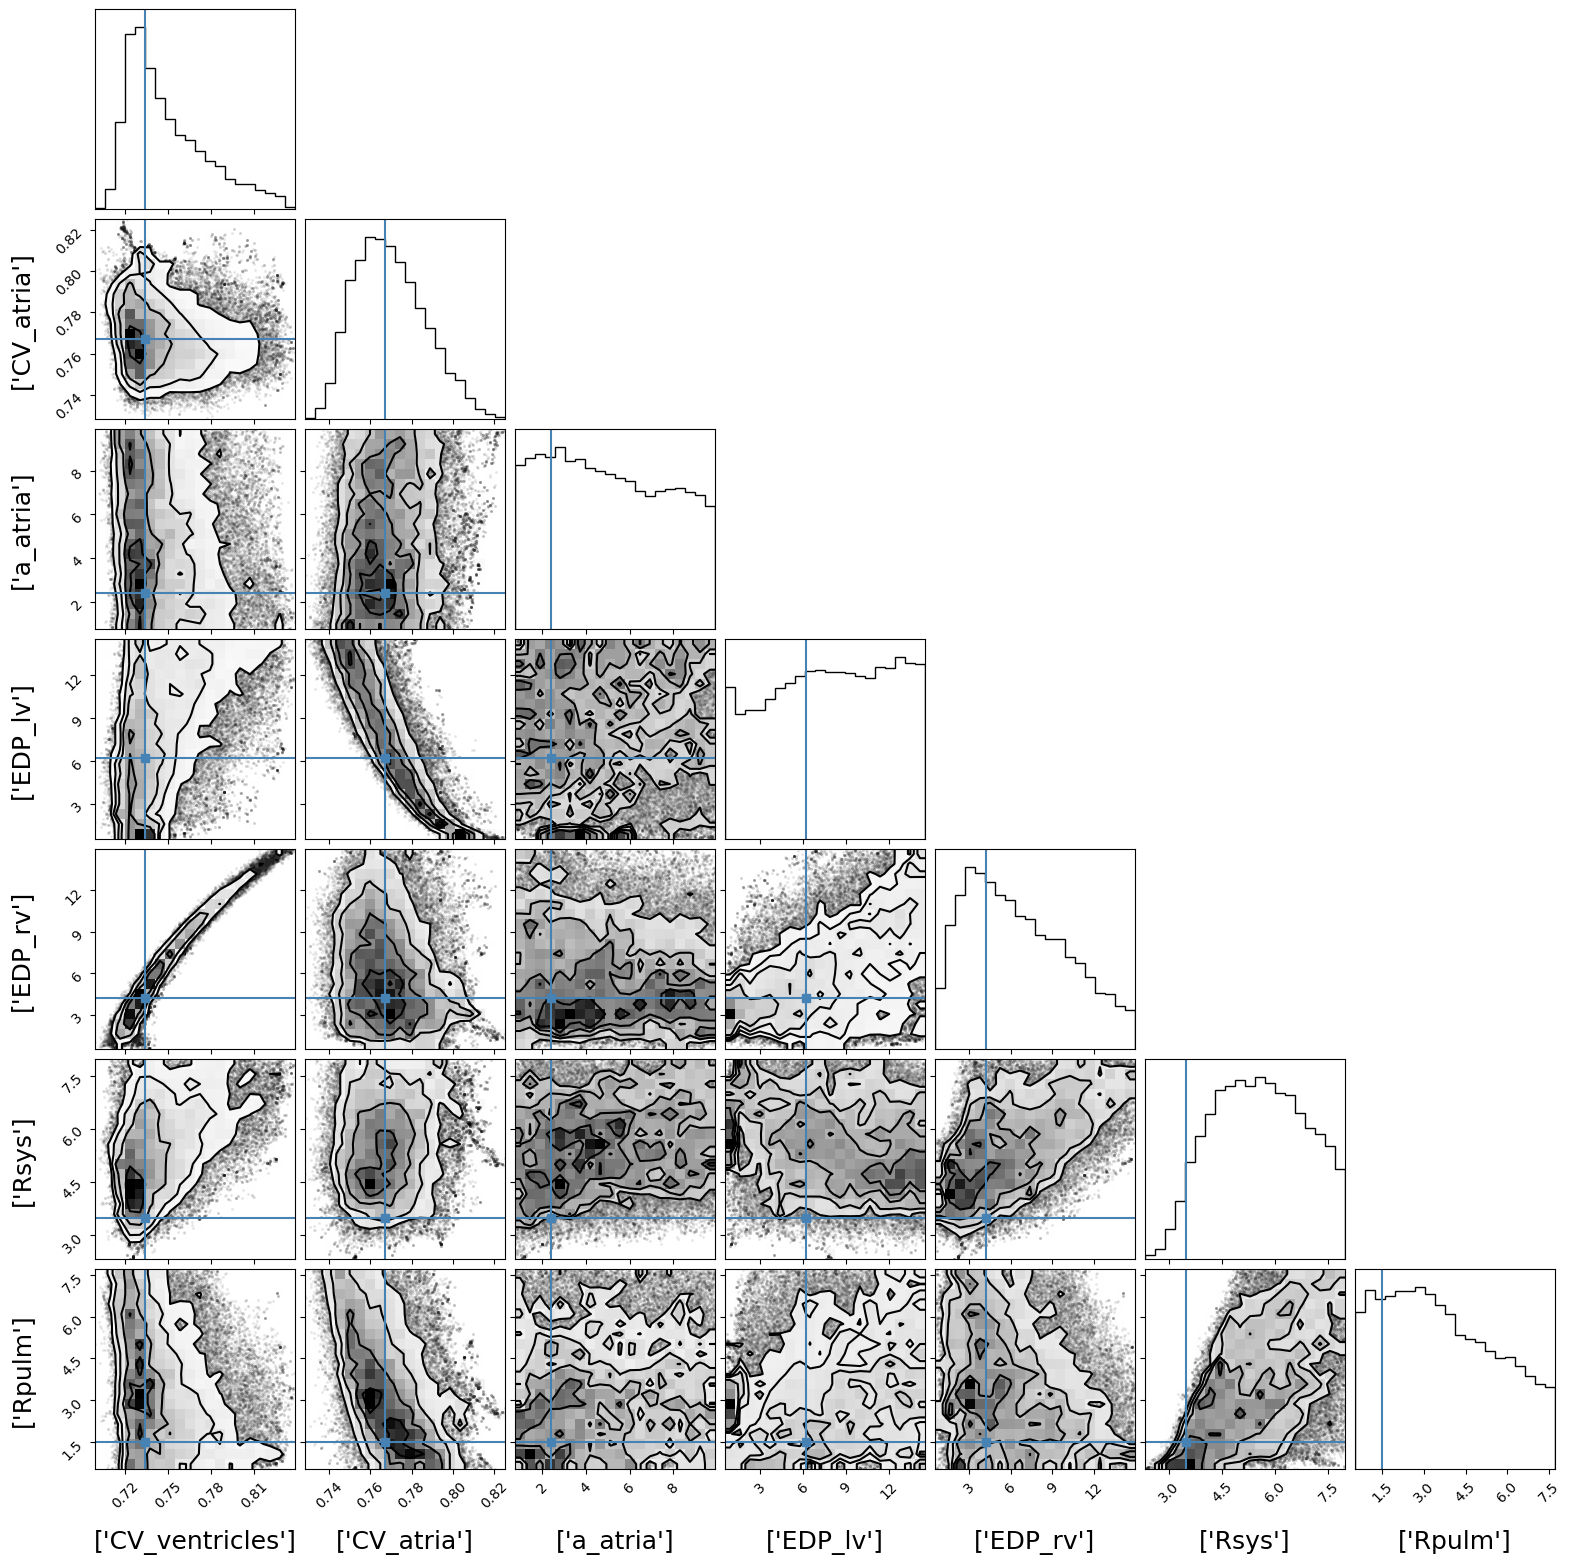

In [55]:
flat_samples = sampler.get_chain(discard=10000, thin=10, flat=True)
print(flat_samples.shape)

x_test

import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values,truths=x_test, label_kwargs=dict(fontsize=18)
);

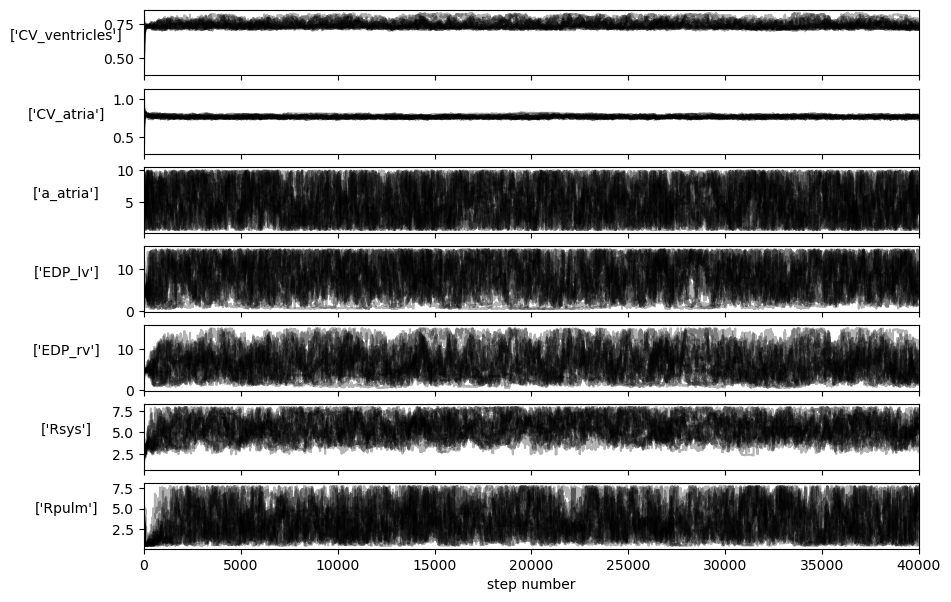

In [56]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [57]:
prediction=emulator.predict(torch.tensor(flat_samples)).detach().numpy()+lasso_model.predict(torch.cat([torch.tensor(flat_samples),torch.tensor(1/flat_samples)],axis=1))

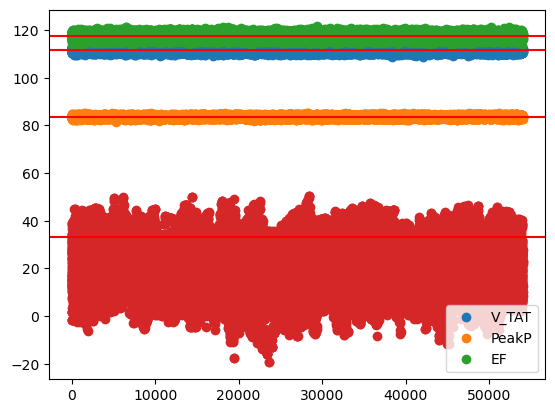

In [58]:
plt.plot(prediction[:,0:3],'o')
plt.plot(prediction[:,3]*100,'o')
plt.legend(('V_TAT','PeakP','EF'),loc='lower right')
plt.axhline(y=y_test[0], color='r', linestyle='-')
plt.axhline(y=y_test[1], color='r', linestyle='-')
plt.axhline(y=y_test[2], color='r', linestyle='-')
plt.axhline(y=y_test[3]*100, color='r', linestyle='-')

In [78]:
y_train = torch.tensor(y_calibration.values)
x_train = torch.tensor(input_masked.values)

x_lasso_train=torch.cat([x_train,1/x_train],axis=1)

In [79]:
y_max=y_train.max(axis=0)

In [80]:
y_max

torch.return_types.max(
values=tensor([286.0400, 161.4530, 117.5800,   0.4480], dtype=torch.float64),
indices=tensor([20, 41, 58, 54]))

In [81]:
y_test = torch.tensor([134,80,133,0.6])

In [46]:
lasso_model = model.fit(x_lasso_train, y_train)

In [47]:
y_shift_train=y_train-torch.tensor(lasso_model.predict(x_lasso_train))

In [48]:
emulator=GPE.ensemble(x_train,y_shift_train,training_iter=1000,mean_func='zero')

0
1
2
3


In [49]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2
ndim = input_masked.shape[1]
nwalkers = 18
p0 = np.random.uniform(0,1,(nwalkers,ndim))*(np.array(boundsMaxMin)[:,1]-np.array(boundsMaxMin)[:,0])+np.array(boundsMaxMin)[:,0]
y_val = y_test[None]
obs_error=torch.tensor([0.1,0.1,0.1,0.1])

In [50]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,lasso_model,y_val,obs_error])

In [51]:
for i in range(nwalkers):
    print(log_prob(p0[i],emulator,lasso_model,y_val,obs_error))

[-873.19477766]
[-11443.2831173]
[-14816.75266599]
[-33667.31292291]
[-15936.74055276]
[-2673.35952647]
[-17188.49362293]
[-13830.92039162]
[-23470.89966644]
[-22203.93249383]
[-13780.95579319]
[-34447.70684582]
[-6498.91770718]
[-23298.51072343]
[-5056.36849555]
[-13267.30523985]
[-6835.96342452]
[-16214.81525982]


In [52]:
sampler.run_mcmc(p0, 40000)

State([[0.7572121  0.63682334 1.84407442 6.9151098  2.05119505 3.93756976
  1.0680599 ]
 [0.75636713 0.64431983 3.20972575 5.83942737 1.14078309 3.90770982
  1.08451231]
 [0.75831856 0.64457896 1.91120346 7.13520499 1.08983623 3.88886897
  1.22227734]
 [0.75257625 0.63997869 1.71187682 6.13761228 2.37782463 3.90070353
  1.05564343]
 [0.75808019 0.63889986 2.3342164  7.12051384 1.1930672  3.84386225
  1.10564708]
 [0.75389356 0.63972174 2.17053115 4.63819244 1.45004524 3.9765823
  1.04516201]
 [0.75901941 0.63987075 1.56018907 6.38798876 1.1706204  3.96844017
  1.38312537]
 [0.75382103 0.63644925 1.57092699 6.14255735 1.38067212 3.85199608
  1.09960281]
 [0.7620428  0.63974934 2.38280386 5.42492033 1.49609802 3.92631082
  1.0811954 ]
 [0.75137469 0.63683727 1.57670263 6.63508117 1.73353437 3.87916708
  1.12058578]
 [0.74890804 0.64745394 1.88015217 4.08153356 1.21781008 3.89385
  1.13834949]
 [0.75322714 0.64435929 2.05914745 6.05201302 1.19587002 3.87572221
  1.04707301]
 [0.75947362 0

(54000, 7)


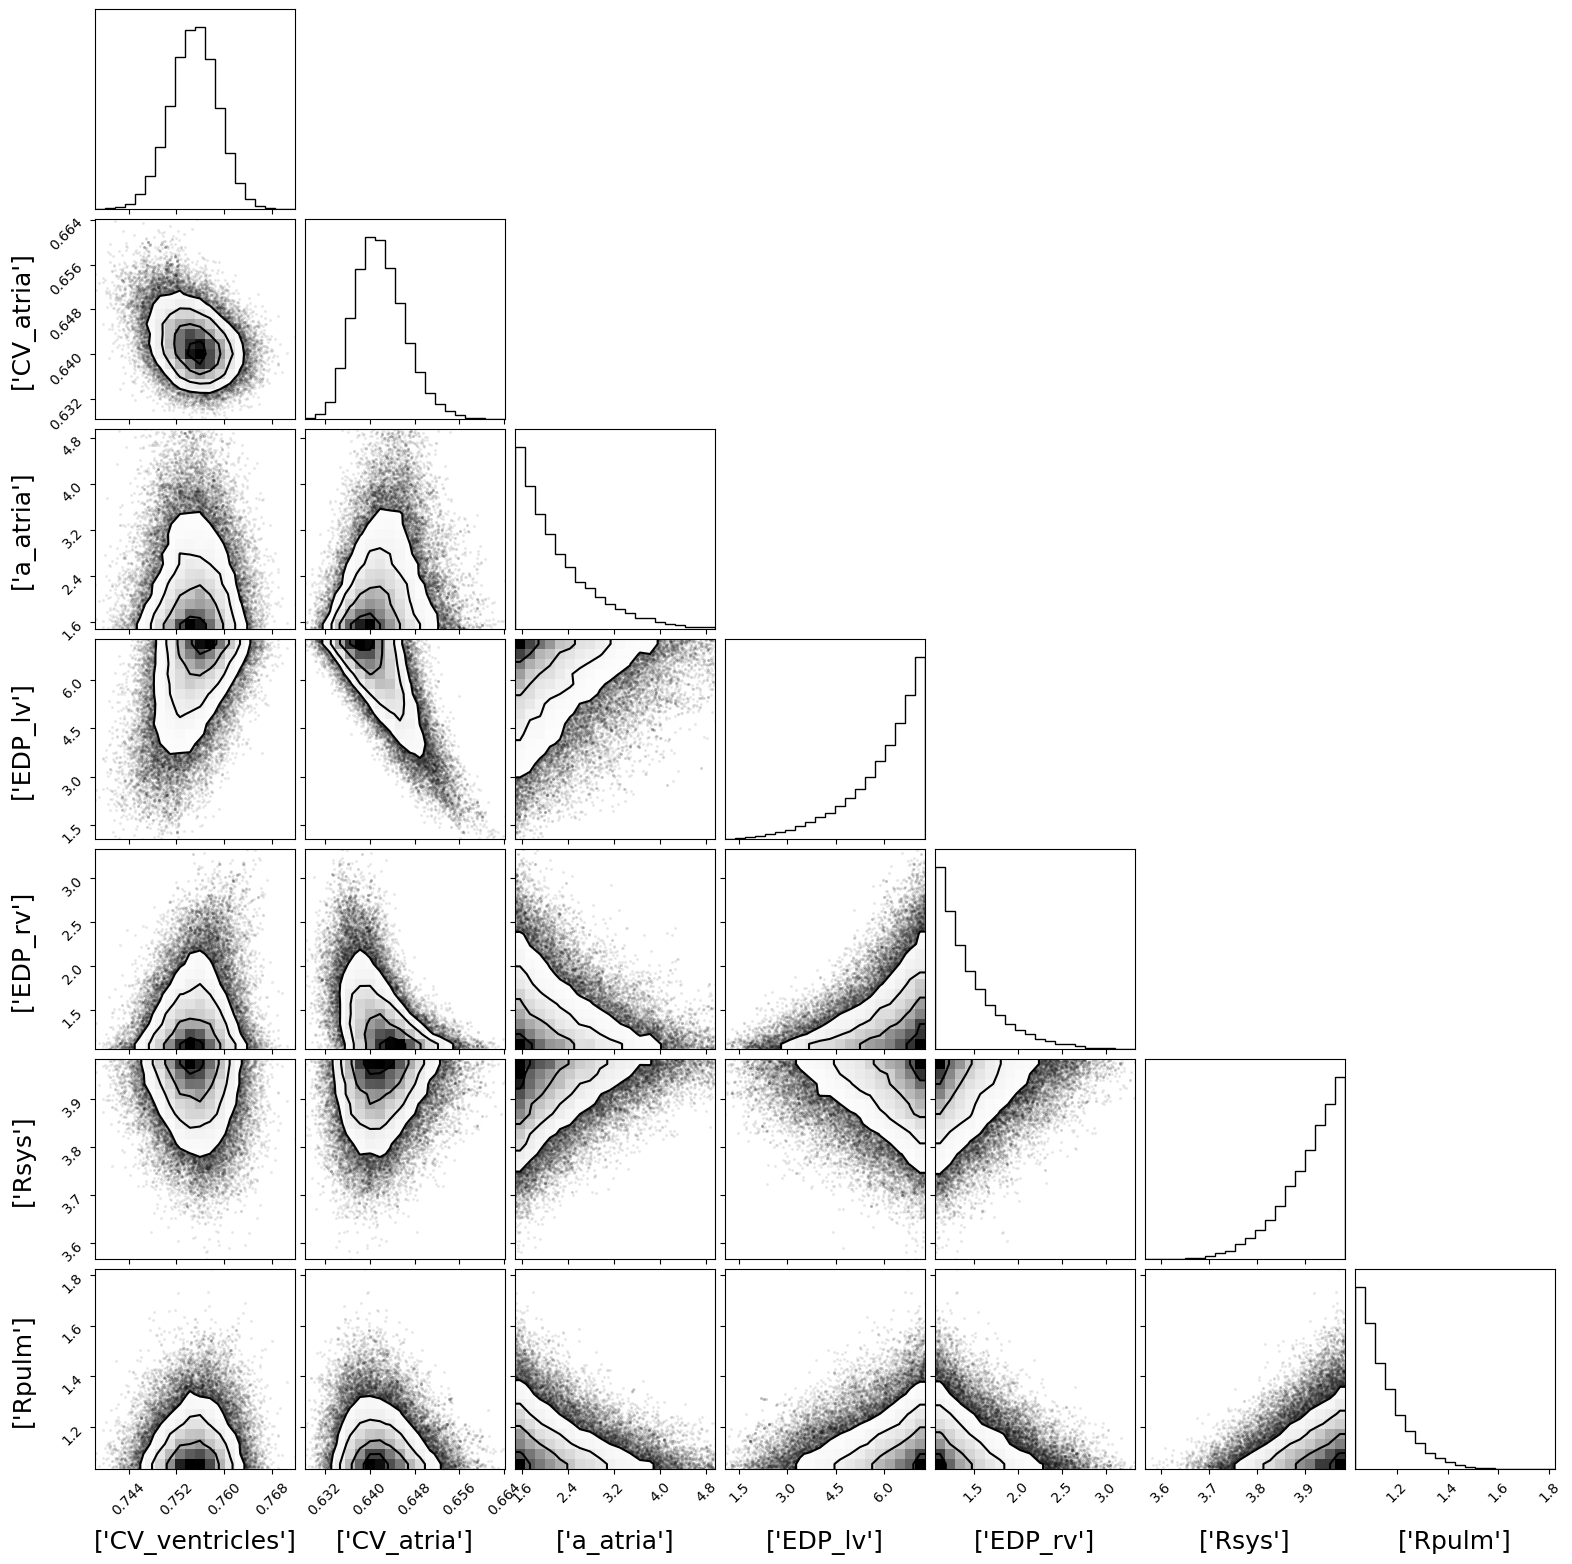

In [54]:
flat_samples = sampler.get_chain(discard=10000, thin=10, flat=True)
print(flat_samples.shape)



import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

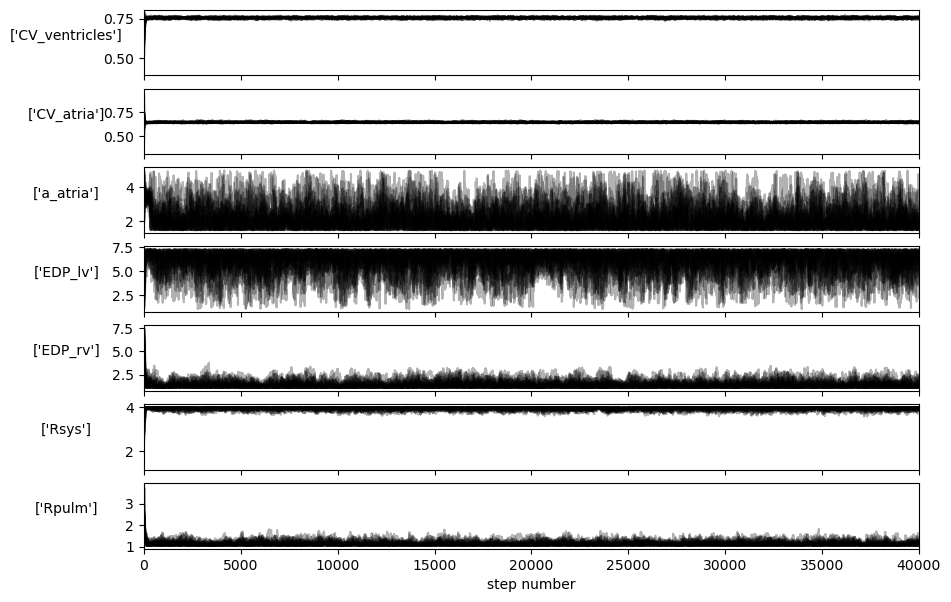

In [55]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [56]:
prediction=emulator.predict(torch.tensor(flat_samples)).detach().numpy()+lasso_model.predict(torch.cat([torch.tensor(flat_samples),torch.tensor(1/flat_samples)],axis=1))

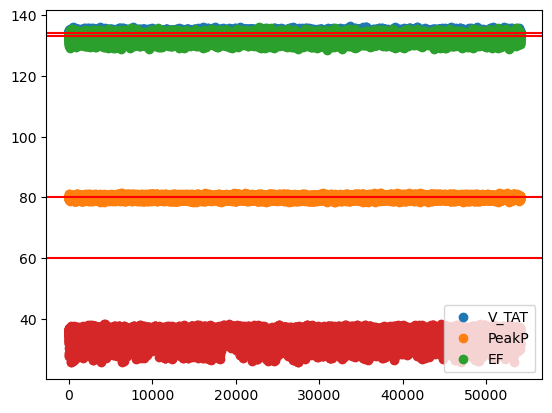

In [57]:
plt.plot(prediction[:,0:3],'o')
plt.plot(prediction[:,3]*100,'o')
plt.legend(('V_TAT','PeakP','EF'),loc='lower right')
plt.axhline(y=y_test[0], color='r', linestyle='-')
plt.axhline(y=y_test[1], color='r', linestyle='-')
plt.axhline(y=y_test[2], color='r', linestyle='-')
plt.axhline(y=y_test[3]*100, color='r', linestyle='-')

In [58]:
x_labels

,0
0,CV_ventricles
1,CV_atria
2,a_atria
3,EDP_lv
4,EDP_rv
5,Rsys
6,Rpulm
